In [1]:
import torch
import torch.nn as nn
from torch_geometric.nn import VGAE, NNConv
from torch_geometric.utils import dropout_edge
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import numpy as np
import pandas as pd
from pathlib import Path

/home/ensai/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random

def set_seed(seed=42):
    """Fixe toutes les graines aléatoires pour la reproductibilité"""
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # si multi-GPU
    
    # NumPy
    np.random.seed(seed)
    
    # Python random
    random.seed(seed)    
    print(f"Seed fixée à: {seed}")

# Appeler au début
set_seed(42)

Seed fixée à: 42


In [3]:
def load_graphs(graph_dir):
    # Vérification du dossier
    graph_dir = Path(graph_dir)
    if not graph_dir.exists():
        raise FileNotFoundError(
            f"Le dossier '{graph_dir}' n'existe pas."
        )
    if not graph_dir.is_dir():
        raise NotADirectoryError(
            f"'{graph_dir}' n'est pas un dossier valide."
        )
    graphs = []
    # Charger tous les fichiers .pt
    for file_path in sorted(graph_dir.glob("*.pt")):
        try:
            g = torch.load(file_path)
            graphs.append(g)
            print(f"Graphe chargé : {file_path}")
        except Exception as e:
            print(f"Erreur lors du chargement de {file_path} : {e}")
    return graphs

# Charger les graphes
train_graphs_dir = "graphs/train"
test_graphs_dir = "graphs/test"

train_graphs = load_graphs(train_graphs_dir)
test_graphs = load_graphs(test_graphs_dir)

/tmp/ipykernel_7877/3133579107.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load(file_path)


Graphe chargé : graphs/train/graph_batch_1.pt
Graphe chargé : graphs/train/graph_batch_10.pt
Graphe chargé : graphs/train/graph_batch_11.pt
Graphe chargé : graphs/train/graph_batch_12.pt
Graphe chargé : graphs/train/graph_batch_2.pt
Graphe chargé : graphs/train/graph_batch_3.pt
Graphe chargé : graphs/train/graph_batch_4.pt
Graphe chargé : graphs/train/graph_batch_5.pt
Graphe chargé : graphs/train/graph_batch_6.pt
Graphe chargé : graphs/train/graph_batch_7.pt
Graphe chargé : graphs/train/graph_batch_8.pt
Graphe chargé : graphs/train/graph_batch_9.pt
Graphe chargé : graphs/test/graph_batch_1.pt
Graphe chargé : graphs/test/graph_batch_2.pt
Graphe chargé : graphs/test/graph_batch_3.pt
Graphe chargé : graphs/test/graph_batch_4.pt
Graphe chargé : graphs/test/graph_batch_5.pt
Graphe chargé : graphs/test/graph_batch_6.pt
Graphe chargé : graphs/test/graph_batch_7.pt


## Split temporel (train / val)

In [4]:
num_graphs = len(train_graphs)

train_ratio = 0.8

train_end = int(train_ratio * num_graphs)

val_graphs   = train_graphs[train_end:]
train_graphs = train_graphs[:train_end]


# Créer un DataLoader pour l'entraînement
# batch_size = nombre de graphes dans chaque batch
batch_size = 1

train_loader = DataLoader(
    train_graphs,
    batch_size=batch_size,
    shuffle=False
)

val_loader = DataLoader(
    val_graphs,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_graphs,
    batch_size=batch_size,
    shuffle=False
)

## Normalisation des features

In [5]:
# concaténation de tous les noeuds du TRAIN
node_xs = torch.cat([g.x for g in train_graphs], dim=0)
edge_xs = torch.cat([g.edge_attr for g in train_graphs], dim=0)

# Calcul des statistiques pour les nœuds
node_mean = node_xs.mean(dim=0)
node_std  = node_xs.std(dim=0, unbiased=False) + 1e-6

# Calcul des statistiques pour les arêtes
edge_mean = edge_xs.mean(dim=0)
edge_std  = edge_xs.std(dim=0, unbiased=False) + 1e-6

def normalize_graph(g, node_mean, node_std, edge_mean, edge_std):
    g = g.clone()
    g.x = (g.x - node_mean) / node_std
    g.edge_attr = (g.edge_attr - edge_mean) / edge_std
    return g


# Normalisation de tous les graphes
train_graphs = [normalize_graph(g, node_mean, node_std, edge_mean, edge_std) for g in train_graphs]
val_graphs   = [normalize_graph(g, node_mean, node_std, edge_mean, edge_std) for g in val_graphs]
test_graphs  = [normalize_graph(g, node_mean, node_std, edge_mean, edge_std) for g in test_graphs]

## Définir l’encodeur

In [6]:
class NNConvEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, edge_dim, edge_latent_dim, dropout=0.1):
        super(NNConvEncoder, self).__init__()

        self.dropout = dropout

        self.edge_mlp1 = nn.Sequential(
            nn.Linear(edge_dim, edge_latent_dim),
            nn.ReLU(),
            nn.Linear(edge_latent_dim, in_channels * 2 * out_channels),
        )

        self.edge_mlp2 = nn.Sequential(
            nn.Linear(edge_dim, edge_latent_dim),
            nn.ReLU(),
            nn.Linear(edge_latent_dim, 2 * out_channels * 2 * out_channels),
        )

        self.edge_mlp_mu = nn.Sequential(
            nn.Linear(edge_dim, edge_latent_dim),
            nn.ReLU(),
            nn.Linear(edge_latent_dim, 2 * out_channels * out_channels),
        )

        self.edge_mlp_logvar = nn.Sequential(
            nn.Linear(edge_dim, edge_latent_dim),
            nn.ReLU(),
            nn.Linear(edge_latent_dim, 2 * out_channels * out_channels),
        )

        # première couche NNConv
        self.conv1 = NNConv(
            in_channels=in_channels,
            out_channels=2 * out_channels,
            nn=self.edge_mlp1,
            aggr='mean'
        )

        self.conv2 = NNConv(
            in_channels=2 * out_channels,
            out_channels=2 * out_channels,
            nn=self.edge_mlp2,
            aggr='mean'
        )

        # ===== BatchNorm =====
        self.bn1 = nn.BatchNorm1d(2 * out_channels)
        self.bn2 = nn.BatchNorm1d(2 * out_channels)

        # ===== Couches latentes =====
        self.conv_mu = NNConv(
            in_channels=2 * out_channels,
            out_channels=out_channels,
            nn=self.edge_mlp_mu,
            aggr='mean'
        )

        self.conv_logvar = NNConv(
            in_channels=2 * out_channels,
            out_channels=out_channels,
            nn=self.edge_mlp_logvar,
            aggr='mean'
        )

    def forward(self, x, edge_index, edge_attr):
        # ===== Dropout des arêtes =====
        edge_index, edge_mask = dropout_edge(edge_index, p=0.1, training=self.training)
        edge_attr = edge_attr[edge_mask]


        # ===== NNConv 1 =====
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # ===== NNConv 2 =====
        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # ===== Latent mu / logvar =====
        mu = self.conv_mu(x, edge_index, edge_attr)
        logvar = self.conv_logvar(x, edge_index, edge_attr)

        return mu, logvar
    

## Créer le modèle VGAE

In [7]:
# Dimensions extraites depuis UN graphe (tous ont la même structure)
in_channels = train_graphs[0].x.shape[1]        # features par nœud
out_channels = 16                               # dimension latente
edge_dim = train_graphs[0].edge_attr.shape[1]   # features par arête
edge_latent_dim = 8                             # latent des arêtes

encoder = NNConvEncoder(in_channels, out_channels, edge_dim, edge_latent_dim)
model = VGAE(encoder)

## Définir l’optimiseur

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr= 5e-4, weight_decay=1e-4)

## Détecter le device (GPU si dispo)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# device = torch.device('cpu')

# Déplacer le modèle
model = model.to(device)

Using device: cuda


## Early Stopping

In [10]:
patience = 50  # nombre d'époques sans amélioration
best_loss = float('inf')
counter = 0

## Entraînement du modèle

In [179]:
num_epochs = 1000
kl_anneal_epochs = 100  # montée progressive de β


for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0

    beta = min(1.0, epoch / kl_anneal_epochs)
    
    # ===== ENTRAÎNEMENT SUR LE PASSÉ =====
    for t, data in enumerate(train_loader):
        assert data.edge_index.dtype == torch.long
        assert data.edge_index.min() >= 0
        assert data.edge_index.max() < data.num_nodes
        # Chaque data = 1 graphe temporel
        data = data.to(device)

        optimizer.zero_grad()
        # Encodage VGAE (NNConv utilise edge_attr)
        z = model.encode(
            data.x,
            data.edge_index,
            data.edge_attr
        )
        # Loss VGAE = reconstruction + KL
        recon_loss = model.recon_loss(z, data.edge_index) / data.num_nodes  # normalisation
        kl_loss = model.kl_loss() / data.num_nodes  # normalisation
        loss = recon_loss + beta * kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # ===== VALIDATION SUR LE FUTUR (SANS BACKPROP) =====
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)

            z = model.encode(
                data.x,
                data.edge_index,
                data.edge_attr
            )

            recon_loss = model.recon_loss(z, data.edge_index) / data.num_nodes  # normalisation
            kl_loss = model.kl_loss() / data.num_nodes

            val_loss += (recon_loss + kl_loss).item()

    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f}"
    )

    # ===== EARLY STOPPING TEMPOREL =====
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_vgae_nnconv.pt")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

Epoch 001 | Train Loss: 21.7973 | Val Loss: 837.8252
Epoch 002 | Train Loss: 37.8543 | Val Loss: 485.2616
Epoch 003 | Train Loss: 38.9671 | Val Loss: 280.2459
Epoch 004 | Train Loss: 36.5308 | Val Loss: 207.6094
Epoch 005 | Train Loss: 44.9456 | Val Loss: 188.2070
Epoch 006 | Train Loss: 26.7884 | Val Loss: 110.3214
Epoch 007 | Train Loss: 28.5280 | Val Loss: 79.5940
Epoch 008 | Train Loss: 23.9417 | Val Loss: 56.6817
Epoch 009 | Train Loss: 22.1403 | Val Loss: 46.8785
Epoch 010 | Train Loss: 19.2110 | Val Loss: 36.1800
Epoch 011 | Train Loss: 14.1380 | Val Loss: 28.2002
Epoch 012 | Train Loss: 20.7256 | Val Loss: 25.5023
Epoch 013 | Train Loss: 17.2331 | Val Loss: 19.8589
Epoch 014 | Train Loss: 11.4548 | Val Loss: 15.1961
Epoch 015 | Train Loss: 23.2446 | Val Loss: 12.5397
Epoch 016 | Train Loss: 11.7561 | Val Loss: 10.0946
Epoch 017 | Train Loss: 9.8955 | Val Loss: 7.6002
Epoch 018 | Train Loss: 10.6506 | Val Loss: 6.1832
Epoch 019 | Train Loss: 7.8236 | Val Loss: 5.4311
Epoch 020 |

## Charger le modèle

In [11]:
# Charger le meilleur modèle
model.load_state_dict(torch.load("best_vgae_nnconv.pt"))


/tmp/ipykernel_7877/2650110910.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vgae_nnconv.pt"))


<All keys matched successfully>

## Score de reconstruction

In [12]:
def edge_recon_error(z, edge_index):
    src, dst = edge_index
    logits = (z[src] * z[dst]).sum(dim=1)
    probs = torch.sigmoid(logits)
    error = -torch.log(probs + 1e-9)
    return error  # [num_edges]


## Agrégation vers les NŒUDS

In [13]:
def node_anomaly_score(z, edge_index, num_nodes):
    edge_error = edge_recon_error(z, edge_index)

    src, dst = edge_index
    node_score = torch.zeros(num_nodes, device=z.device)
    node_score.scatter_add_(0, src, edge_error)
    node_score.scatter_add_(0, dst, edge_error)

    degree = torch.zeros(num_nodes, device=z.device)
    degree.scatter_add_(0, src, torch.ones_like(edge_error))
    degree.scatter_add_(0, dst, torch.ones_like(edge_error))

    return node_score / (degree + 1e-6)


## Collecte sur les données de valisation

In [14]:
val_scores = []
val_labels = []

model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        z = model.encode(
            data.x,
            data.edge_index,
            data.edge_attr
        )

        scores = node_anomaly_score(
            z,
            data.edge_index,
            data.num_nodes
        )

        print("data.y:", data.y)
        print("scores:", scores.shape)

        val_scores.extend(scores.cpu().numpy())
        val_labels.extend(data.y.cpu().numpy())


data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([30058])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([85848])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([88759])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([69533])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([69348])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([72635])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([139538])


## Choisir un seuil

In [15]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(val_labels, val_scores)

# Exemple : maximiser F1
f1 = 2 * precision * recall / (precision + recall + 1e-9)
best_idx = np.argmax(f1)

best_threshold = thresholds[best_idx]
print("Best threshold:", best_threshold)
print("Precision:", precision[best_idx])
print("Recall:", recall[best_idx])


Best threshold: 0.7529783
Precision: 0.1043956043956044
Recall: 0.30116550116550117


In [16]:
threshold = best_threshold
# threshold = np.percentile(val_scores, 99)


## TEST

In [17]:
test_scores = []
test_labels = []
test_preds  = []
test_transaction_ids = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        z = model.encode(
            data.x,
            data.edge_index,
            data.edge_attr
        )

        scores = node_anomaly_score(
            z,
            data.edge_index,
            data.num_nodes
        )

        preds = (scores > threshold).long()

        test_scores.extend(scores.cpu().numpy())
        test_labels.extend(data.y.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())
        test_transaction_ids.extend(data.tx_id.cpu().numpy())


In [18]:
test_transaction_df = pd.DataFrame({
    "transaction_id": test_transaction_ids,
    "score": test_scores,
    "prediction": test_preds,
    "label": test_labels
})

test_transaction_df.to_csv("predictions.csv", index=False)

## Matrice de confusion

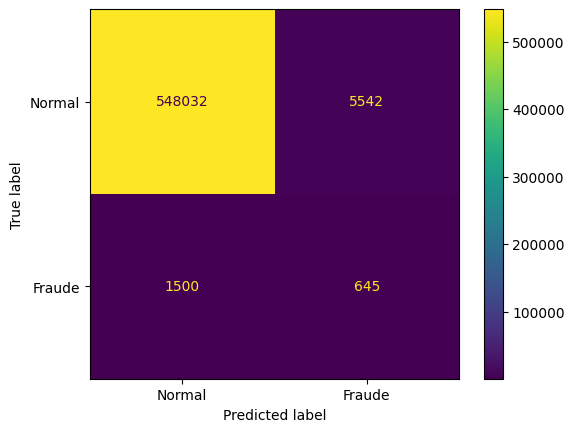

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, test_preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Normal", "Fraude"]
)
disp.plot()


## Importance des features

In [20]:
# Importance des features de nœuds
def permutation_importance_node(
    model, data, baseline_scores, feature_idx, device
):
    data_perm = data.clone()
    data_perm.x = data_perm.x.to(device)

    perm = torch.randperm(data_perm.x.size(0))
    data_perm.x[:, feature_idx] = data_perm.x[perm, feature_idx]

    model = model.to(device)
    model.eval()
    
    with torch.no_grad():
        z = model.encode(
            data_perm.x,
            data_perm.edge_index,
            data_perm.edge_attr
        )
        scores = node_anomaly_score(
            z,
            data_perm.edge_index,
            data_perm.num_nodes
        )
    return torch.mean(torch.abs(scores - baseline_scores))

baseline_scores = scores.detach()

importances = []

for k in range(data.x.shape[1]):
    imp = permutation_importance_node(
        model, data, baseline_scores, k, device
    )
    importances.append(imp.item())

importances = np.array(importances)

node_feature_names = [
    # Transaction features
    "amt",
    "hour",
    "is_night_tx",
    "dayofweek",
    "is_weekend",
    "age",
    "is_new_merchant",
    # "card_time_since_prev_tx",
    # "dist_from_prev_tx",
    "dist_from_home",
    "is_impossible_travel",
    "category_idx",
    "is_category_shift",

    # Card features
    "amt_zscore",
    "amt_vs_card_mean_ratio",
    "amt_minus_prev_max",
    "amt_minus_prev_min",
    "card_amt_mean",
    "card_amt_std",
    "tx_count_1h",
    "tx_count_24h",
    "amt_sum_1h",
    
    # Identity
    "gender_idx", "job_idx",
    "city_pop",

    # Mercahnt feature
    "merchant_avg_amt",
    "merchant_time_since_prev_tx",
    "amt_vs_merchant_avg_ratio",
]


importance_df = pd.DataFrame({
    "feature": node_feature_names,
    "importance": importances
})

# Tri décroissant
importance_df = importance_df.sort_values(
    by="importance",
    ascending=False
)

pd.set_option("display.float_format", "{:.2e}".format)
print(importance_df)


                        feature  importance
22                     city_pop    6.01e-03
24  merchant_time_since_prev_tx    2.76e-03
13           amt_minus_prev_max    3.63e-04
14           amt_minus_prev_min    9.95e-05
21                      job_idx    8.44e-05
0                           amt    7.58e-05
19                   amt_sum_1h    2.54e-05
16                 card_amt_std    1.26e-05
5                           age    9.12e-06
7                dist_from_home    4.23e-06
23             merchant_avg_amt    2.98e-06
15                card_amt_mean    2.47e-06
9                  category_idx    1.32e-06
3                     dayofweek    1.00e-06
18                 tx_count_24h    7.43e-07
1                          hour    6.74e-07
12       amt_vs_card_mean_ratio    5.66e-07
25    amt_vs_merchant_avg_ratio    5.55e-07
17                  tx_count_1h    3.42e-07
11                   amt_zscore    2.97e-07
4                    is_weekend    1.42e-07
10            is_category_shift 

In [21]:
# Importance des features d’arêtes
def permutation_importance_edge(
    model, data, baseline_scores, feature_idx, device
):
    data_perm = data.clone()
    data_perm.x = data_perm.x.to(device)
    
    perm = torch.randperm(data_perm.edge_attr.size(0))
    data_perm.edge_attr[:, feature_idx] = data_perm.edge_attr[perm, feature_idx]

    model = model.to(device)
    model.eval()

    with torch.no_grad():
        z = model.encode(
            data_perm.x,
            data_perm.edge_index,
            data_perm.edge_attr
        )
        scores = node_anomaly_score(
            z,
            data_perm.edge_index,
            data_perm.num_nodes
        )
    return torch.mean(torch.abs(scores - baseline_scores))

baseline_scores = scores.detach()

edge_importances = []
for k in range(data.edge_attr.shape[1]):
    imp = permutation_importance_edge(
        model, data, baseline_scores, k, device
    )
    edge_importances.append(imp.item())

edge_importances = np.array(edge_importances)

edge_feature_names = [
    "delta_time_log",   # np.log1p(dt)
    "amount_diff",      # |amt_j - amt_i|
    "amount_ratio",     # amt_j / amt_i
    "geo_jump",         # |geo_j - geo_i|
]

edge_importance_df = pd.DataFrame({
    "feature": edge_feature_names,
    "importance": edge_importances
}).sort_values("importance", ascending=False)

print(edge_importance_df)


          feature  importance
1     amount_diff    2.17e-02
3        geo_jump    7.44e-03
2    amount_ratio    4.44e-03
0  delta_time_log    4.03e-04


## Faux positifs / faux négatifs

In [22]:
fp = []
fn = []

offset = 0
for data in test_loader:
    n = data.num_nodes
    labels = np.array(test_labels[offset:offset+n])
    preds  = np.array(test_preds[offset:offset+n])
    scores = np.array(test_scores[offset:offset+n])

    for i in range(n):
        if preds[i] == 1 and labels[i] == 0:
            fp.append((data, i, scores[i]))
        if preds[i] == 0 and labels[i] == 1:
            fn.append((data, i, scores[i]))

    offset += n

### faux positifs

In [23]:
# On cherche celui avec le score maximal
data_fp, node_id_fp, score_fp = max(fp, key=lambda x: x[2])  # x[2] = score_fp

tx_id = data_fp.tx_id[node_id_fp].item()
print("Transaction ID in the test dataset:", tx_id)

Transaction ID in the test dataset: 82864


In [24]:
# Features du nœud
node_features = data_fp.x[node_id_fp]

# Label réel / prédiction
true_label = data_fp.y[node_id_fp].item()
pred_label = 1  # par définition FP

print("Node ID:", node_id_fp)
print("Score anomalie:", score_fp)
print("Label réel:", true_label)

feature_df = pd.DataFrame({
    "feature name": node_feature_names,
    "feature value": node_features
})

pd.set_option("display.float_format", "{:.3f}".format)

print(print(feature_df.to_string(index=False)))


Node ID: 29727
Score anomalie: 20.723257
Label réel: 0
               feature name  feature value
                        amt        724.160
                       hour          6.000
                is_night_tx          0.000
                  dayofweek          0.000
                 is_weekend          0.000
                        age         57.621
            is_new_merchant          1.000
             dist_from_home          4.453
       is_impossible_travel          0.000
               category_idx          8.000
          is_category_shift          1.000
                 amt_zscore          0.538
     amt_vs_card_mean_ratio          4.022
         amt_minus_prev_max      -7784.180
         amt_minus_prev_min        722.970
              card_amt_mean        180.051
               card_amt_std       1011.418
                tx_count_1h          1.000
               tx_count_24h          3.000
                 amt_sum_1h         90.270
                 gender_idx          0.000

In [25]:
# Arêtes incidentes au FP
src, dst = data_fp.edge_index
edge_mask = (src == node_id_fp) | (dst == node_id_fp)
edge_ids = edge_mask.nonzero(as_tuple=True)[0]

# Features de ces arêtes (normalisées)
incident_edge_features = data_fp.edge_attr[edge_ids]

# Créer une liste de dictionnaires pour chaque arête
rows = []
for i, eid in enumerate(edge_ids):
    row = {"edge_id": eid.item()}
    for j, fname in enumerate(edge_feature_names):
        row[fname] = incident_edge_features[i, j].item()
    # Ajouter type de connexion : entrante ou sortante
    if src[eid] == node_id_fp:
        row["type"] = "sortante"
    else:
        row["type"] = "entrante"
    rows.append(row)

edge_feature_df = pd.DataFrame(rows)
print(edge_feature_df.to_string(index=False))


 edge_id  delta_time_log  amount_diff  amount_ratio  geo_jump     type
   29412          10.010      633.890         8.022    20.706 entrante
   29413          10.353      638.960         0.118    80.202 sortante


In [26]:
fp_node_id = node_id_fp

neighbor_ids = torch.unique(
    torch.cat([src[edge_ids], dst[edge_ids]])
)

neighbor_ids = neighbor_ids[neighbor_ids != fp_node_id]  # exclure le FP

# Créer une matrice de features : lignes = features, colonnes = nœuds
all_node_ids = [fp_node_id] + neighbor_ids.tolist()

features_matrix = []
for feat_idx in range(data_fp.x.shape[1]):
    row = [data_fp.x[nid, feat_idx].item() for nid in all_node_ids]
    features_matrix.append(row)


# Déterminer le type de connexion (entrante / sortante) pour chaque voisin
direction_dict = {}
for eid in edge_ids:
    if src[eid] == fp_node_id:
        neighbor = dst[eid].item()
        direction_dict[neighbor] = "sortante"
    else:
        neighbor = src[eid].item()
        direction_dict[neighbor] = "entrante"

# Créer un DataFrame
col_names = ["FP"] + [f"{direction_dict[nid]}" for nid in neighbor_ids.tolist()]
row_names = node_feature_names

node_features_df = pd.DataFrame(features_matrix, columns=col_names, index=row_names)

print(node_features_df)

                                   FP  entrante  sortante
amt                           724.160    90.270    85.200
hour                            6.000     0.000    15.000
is_night_tx                     0.000     1.000     0.000
dayofweek                       0.000     0.000     0.000
is_weekend                      0.000     0.000     0.000
age                            57.621    57.621    57.621
is_new_merchant                 1.000     1.000     1.000
dist_from_home                  4.453    16.600    77.766
is_impossible_travel            0.000     0.000     0.000
category_idx                    8.000     4.000    10.000
is_category_shift               1.000     1.000     1.000
amt_zscore                      0.538    -0.089    -0.102
amt_vs_card_mean_ratio          4.022     0.498     0.454
amt_minus_prev_max          -7784.180 -8418.070 -8423.140
amt_minus_prev_min            722.970    89.080    84.010
card_amt_mean                 180.051   181.352   187.714
card_amt_std  

### faux négatifs

In [27]:
# On cherche celui avec le score minimal
data_fn, node_id_fn, score_fn = min(fn, key=lambda x: x[2])  # x[2] = score_fn

tx_id = data_fn.tx_id[node_id_fn].item()
print("Transaction ID in the test dataset:", tx_id)

Transaction ID in the test dataset: 36108


In [28]:
# Features du nœud
node_features = data_fn.x[node_id_fn]

# Label réel / prédiction
true_label = data_fn.y[node_id_fn].item()
pred_label = 0  # par définition FN

print("Node ID:", node_id_fn)
print("Score anomalie:", score_fn)
print("Label réel:", true_label)

feature_df = pd.DataFrame({
    "feature name": node_feature_names,
    "feature value": node_features
})

pd.set_option("display.float_format", "{:.3f}".format)

print(print(feature_df.to_string(index=False)))


Node ID: 26254
Score anomalie: 0.0
Label réel: 1
               feature name  feature value
                        amt         10.320
                       hour         22.000
                is_night_tx          0.000
                  dayofweek          4.000
                 is_weekend          0.000
                        age         76.093
            is_new_merchant          1.000
             dist_from_home         68.825
       is_impossible_travel          0.000
               category_idx         13.000
          is_category_shift          1.000
                 amt_zscore         -0.848
     amt_vs_card_mean_ratio          0.025
         amt_minus_prev_max      -1105.620
         amt_minus_prev_min          1.290
              card_amt_mean        418.547
               card_amt_std        481.591
                tx_count_1h          1.000
               tx_count_24h          4.000
                 amt_sum_1h       1115.940
                 gender_idx          0.000
     

In [29]:
# Arêtes incidentes au FN
src, dst = data_fn.edge_index
edge_mask = (src == node_id_fn) | (dst == node_id_fn)
edge_ids = edge_mask.nonzero(as_tuple=True)[0]

# Features de ces arêtes (normalisées)
incident_edge_features = data_fn.edge_attr[edge_ids]

# Créer une liste de dictionnaires pour chaque arête
rows = []
for i, eid in enumerate(edge_ids):
    row = {"edge_id": eid.item()}
    for j, fname in enumerate(edge_feature_names):
        row[fname] = incident_edge_features[i, j].item()
    # Ajouter type de connexion : entrante ou sortante
    if src[eid] == node_id_fn:
        row["type"] = "sortante"
    else:
        row["type"] = "entrante"
    rows.append(row)

edge_feature_df = pd.DataFrame(rows)
print(edge_feature_df.to_string(index=False))


 edge_id  delta_time_log  amount_diff  amount_ratio  geo_jump     type
   25977           7.341     1105.620         0.009    72.374 entrante
   25978           6.893      902.570        88.458   102.569 sortante


In [30]:
fn_node_id = node_id_fn

neighbor_ids = torch.unique(
    torch.cat([src[edge_ids], dst[edge_ids]])
)

neighbor_ids = neighbor_ids[neighbor_ids != fn_node_id]  # exclure le FN

# Créer une matrice de features : lignes = features, colonnes = nœuds
all_node_ids = [fn_node_id] + neighbor_ids.tolist()

features_matrix = []
for feat_idx in range(data_fn.x.shape[1]):
    row = [data_fn.x[nid, feat_idx].item() for nid in all_node_ids]
    features_matrix.append(row)


# Déterminer le type de connexion (entrante / sortante) pour chaque voisin
direction_dict = {}
for eid in edge_ids:
    if src[eid] == fn_node_id:
        neighbor = dst[eid].item()
        direction_dict[neighbor] = "sortante"
    else:
        neighbor = src[eid].item()
        direction_dict[neighbor] = "entrante"

# Créer un DataFrame
col_names = ["FN"] + [f"{direction_dict[nid]}" for nid in neighbor_ids.tolist()]
row_names = node_feature_names

node_features_df = pd.DataFrame(features_matrix, columns=col_names, index=row_names)

print(node_features_df)

                                   FN  entrante  sortante
amt                            10.320  1115.940   912.890
hour                           22.000    22.000    23.000
is_night_tx                     0.000     0.000     0.000
dayofweek                       4.000     4.000     4.000
is_weekend                      0.000     0.000     0.000
age                            76.093    76.093    76.093
is_new_merchant                 1.000     1.000     1.000
dist_from_home                 68.825    24.259    38.929
is_impossible_travel            0.000     0.000     0.000
category_idx                   13.000    11.000     8.000
is_category_shift               1.000     1.000     1.000
amt_zscore                     -0.848     6.045     1.265
amt_vs_card_mean_ratio          0.025     5.997     2.710
amt_minus_prev_max          -1105.620   829.210  -203.050
amt_minus_prev_min              1.290  1106.910   903.860
card_amt_mean                 418.547   186.083   336.902
card_amt_std  